In [12]:
import numpy as np
import pandas
from ipywidgets import FloatProgress
from IPython.display import display

def d20():
    return np.random.randint(1,21)

def do_rounds_and_update(a,b,rounds,df):
    wins = do_match(a,b,rounds)
    a_wins = wins[0]
    b_wins = wins[1]
    a_id = a[0]
    b_id = b[0]
    df.at[a_id,'total_wins'] = df.at[a_id,'total_wins'] + a_wins
    df.at[b_id,'total_wins'] = df.at[b_id,'total_wins'] + b_wins
    if a_wins > b_wins:
        df.at[a_id,'pair_wins'] = df.at[a_id,'pair_wins'] + 1
    else:
        df.at[b_id,'pair_wins'] = df.at[b_id,'pair_wins'] + 1
    return creatures

def do_match(a,b,rounds):
    a_wins = 0
    b_wins = 0
    for _ in np.arange(rounds):
        wins = do_round(a,b)
        a_wins = a_wins + wins[0]
        b_wins = b_wins + wins[1]
    if debug_matches:
        print ("After %d rounds %s won %d times and %s won %d times" % (rounds,a.name,a_wins,b.name,b_wins))
    return [a_wins,b_wins]

def do_round( a, b ):
    a_init = d20() + a.init
    if debug_rounds:
        print("%s rolled %d init" % (a.name,a_init))
    b_init = d20() + b.init
    if debug_rounds:
        print("%s rolled %d init" % (b.name,b_init))
    if (a_init >= b_init):
        first = a.copy()
        second = b.copy()
        in_order = True
    else:
        first = b.copy()
        second = a.copy()
        in_order = False
    round = 0
    while (first.hp > 0 and second.hp > 0):
        if debug_rounds:
            print("    Round %d: %s hp is %d and %s hp is %d" % (round+1, first.name,first.hp,second.name,second.hp))
        round = round + 1
        first,second = do_attack(first,second)
        if (second.hp <= 0):
            if debug_rounds:
                print("%s is dead" % second.name)
            if in_order:
                return [1,0] #a went first and won
            else:
                return [0,1] #b went first and won
        else:
            second,first = do_attack(second,first)
            if (first.hp <= 0):
                if debug_rounds:
                    print("%s is dead" % first.name)
                if in_order:
                    return [0,1] #b went second and won
                else:
                    return [1,0] #a went second and won
    """Something went wrong here, nobody wins"""
    return [0,0]
    
def do_attack( attacker, target ):
    if debug_rounds:
        print ("        %s makes %d attacks against %s" % (attacker.name, attacker.att_num, target.name))
    for _ in np.arange(attacker.att_num):
        attack = d20() + attacker.hit_mod
        if (attack >= target.ac):
            target.hp = target.hp - attacker.dam_avg
            if debug_rounds:
                print("            %s hits %s for %d damage" % (attacker.name, target.name, attacker.dam_avg ))
        else:
            if debug_rounds:
                print("            %s misses %s" % (attacker.name, target.name))
    return [attacker, target]

In [13]:
debug_rounds = False
debug_matches = False
# rounds for a 95% confidence interval in accordance with:
# https://calhoun.nps.edu/bitstream/handle/10945/798/NPS-MAE-04-005.pdf?sequence=1
rounds = 100
creatures = pandas.read_csv('creatures.csv')
rows = creatures.shape[0]
creatures['pair_wins'] = np.zeros(rows)
creatures['total_wins'] = np.zeros(rows)

# a = creatures.sample(1).to_records()[0]
# b = creatures.sample(1).to_records()[0]
# a = creatures.take([0]).to_records()[0]
# b = creatures.take([1]).to_records()[0]
# do_rounds_and_update(a,b,rounds,creatures)
# creatures.loc[creatures['total_wins'] > 0]

matches = (rows**2+rows)/2

f = FloatProgress(min=0, max=matches, description="Contests: ")
display(f)

print("Performing %'d matches of %'d rounds each" % (matches,rounds))
for i in np.arange(rows):
    a = creatures.take([i]).to_records()[0]
    for j in np.arange(i+1,rows):
        b = creatures.take([j]).to_records()[0]
        creatures = do_rounds_and_update(a,b,rounds,creatures)
        f.value = f.value + 1

FloatProgress(value=0.0, description='Running contests: ', max=52975.0)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11bd23780>]],
      dtype=object)

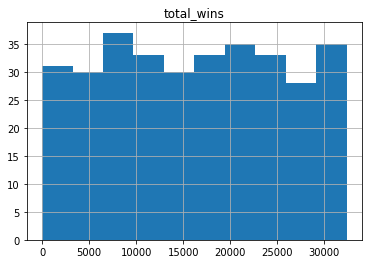

In [15]:
filename = "creatures_%02d.csv" % (rounds)
creatures.to_csv(filename)
creatures.sort_values(['total_wins','pair_wins'],ascending=[0,0])
creatures.hist('total_wins')